In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(13, 3))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


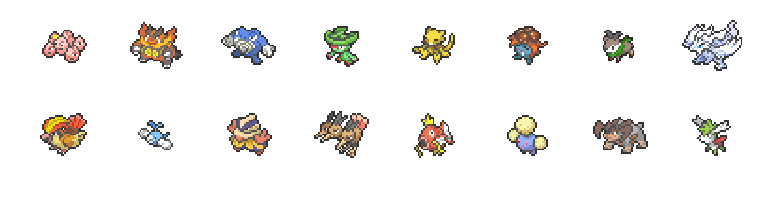

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
plotPoke(orig_img)

In [4]:
# Flat all data to one dimension
X_flat = orig_img.reshape((-1,1600))    
    
print 'Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape)

Original image shape:  (792, 40, 40, 3)
Flatted image shape:  (2376, 1600)


In [5]:
# Transpose RGB channels into 3 different independent image
# Then flatted all pixel into one dimension
X_flat = np.transpose(orig_img, (0,3,1,2))
X_flat = X_flat.reshape(2376, 1600)

print 'Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape)

Original image shape:  (792, 40, 40, 3)
Flatted image shape:  (2376, 1600)


In [6]:
# Parameters
learning_rate = 0.001
training_epochs = 30000
batch_size = 36
display_step = 1000
examples_to_show = 8

# Network Parameters
n_hidden_1 = 1024
n_hidden_2 = 512
n_hidden_3 = 256
n_input = 1600 # Pokemon input (img shape: 40*40)

In [7]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.01)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2], stddev=0.01)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.01)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.01))
}
biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'encoder_b3': tf.Variable(tf.truncated_normal([n_hidden_3], stddev=0.01)),
    'decoder_b1': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'decoder_b2': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'decoder_b3': tf.Variable(tf.truncated_normal([n_input], stddev=0.01))
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                  biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                  biases['encoder_b3']))
    return layer_3

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_3

In [8]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the MSE
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [9]:
# Initializing the variables
init = tf.global_variables_initializer()

# Create session and graph, initial variables
sess = tf.InteractiveSession()
sess.run(init)

In [ ]:
# Load previous trained model and rewrite to variables, if exists
# Before run this cell, you have to run the cell above first, to define variables and init it.
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)

weightSaver.restore(sess, "./saved_model/AE_RGB_weights.ckpt")
biaseSaver.restore(sess, "./saved_model/AE_RGB_biases.ckpt")

print "Model restored."

In [10]:
total_batch = int(X_flat.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size
    for i in range(total_batch-1):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = X_flat[index]
        start = end; end = start+batch_size
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:05d}   loss: {1:f}'.format(epoch+1, c)

print("Optimization Finished!")

Epoch: 00001   loss: 0.219377
Epoch: 01000   loss: 0.025602
Epoch: 02000   loss: 0.018032
Epoch: 03000   loss: 0.008081
Epoch: 04000   loss: 0.003557
Epoch: 05000   loss: 0.002147
Epoch: 06000   loss: 0.001671
Epoch: 07000   loss: 0.001412
Epoch: 08000   loss: 0.001278
Epoch: 09000   loss: 0.001143
Epoch: 10000   loss: 0.001024
Epoch: 11000   loss: 0.000957
Epoch: 12000   loss: 0.000894
Epoch: 13000   loss: 0.000856
Epoch: 14000   loss: 0.000809
Epoch: 15000   loss: 0.000772
Epoch: 16000   loss: 0.000750
Epoch: 17000   loss: 0.000725


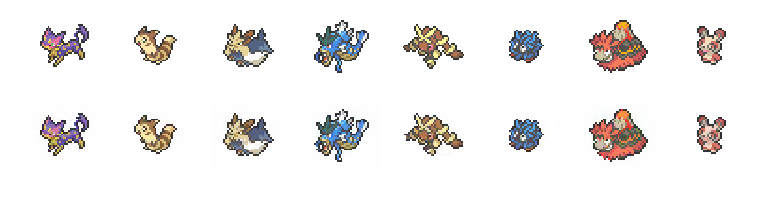

In [11]:
# Random select some pokemon to visualization
# index are picked in orig_img.shape[0], then transform to X_flat with correspond RGB row
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
index = np.sort(index)
RGB_index = np.concatenate((index*3, index*3+1, index*3+2))
RGB_index = np.sort(RGB_index)
autoencoder = sess.run(
    y_pred, feed_dict={X: X_flat[RGB_index]})

# merge RGB rows back to RGB matrix
autoencoder = np.reshape(autoencoder, (examples_to_show, 3, 40, 40))
autoencoder = np.transpose(autoencoder, (0,2,3,1))

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(13, 3))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(autoencoder[i])
    a[1,i].axis('off')
f.show()
plt.draw()

In [12]:
# Save weights and biases
weights_saver = tf.train.Saver(var_list=weights)
biases_saver = tf.train.Saver(var_list=biases)
weights_saver.save(sess, './saved_model/AE_RGB_weights')
biases_saver.save(sess, './saved_model/AE_RGB_biases')

'AE_RGB_biases'